<a href="https://colab.research.google.com/github/Mathvivas/agents/blob/main/Github_Web_Study_Agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hugging Face Agent that searches Github and Web to find answers

In [1]:
%pip install -q -U langchain-huggingface langchain-core langchain-community langchain-tavily langgraph langsmith

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 53.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.4/157.4 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 4.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.


In [2]:
from google.colab import userdata
HUGGIN_FACE_API_KEY = userdata.get('HF_TOKEN')
TAVILY_API_KEY = userdata.get('TAVILY')
GITHUB_API_KEY = userdata.get('GITHUB_API_KEY')

In [3]:
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace

## Creating the Tools

### Web (Tavily)

In [4]:
from langchain_tavily import TavilySearch
from langchain_core.tools import tool
import requests

In [5]:
@tool
def search_web(query: str) -> list:
    """
    Searches web for information based on a query.
    """
    tavily_search = TavilySearch(max_results=2,
                                search_depth='advanced',
                                max_tokens=1000)
    search_result = tavily_search.invoke(query)
    return search_result

### Github

In [6]:
@tool
def search_github(query: str) -> str:
    """
    Searches Github repositories related to a technolofy or concept.
    Returns repo names, descriptions, stars and URLs.
    """
    headers = {
        'Authorization': f'token {GITHUB_API_KEY}'
    }

    url = 'https://api.github.com/search/repositories'
    params = {
        'q': query,
        'sort': 'stars',
        'order': 'desc',
        'per_page': 5
    }

    try:
        response = requests.get(url, headers=headers, params=params)
        response.raise_for_status()
        data = response.json()

        if 'items' not in data or len(data['items']) == 0:
            return f'No repositories found for query: {query}'

        results = []
        for repo in data.get('items', []):
            results.append(
                f'- {repo["full_name"]} - ⭐ {repo["stargazers_count"]}\n'
                f' {repo["description"]}\n'
                f' {repo["html_url"]}'
            )
        return '\n\n'.join(results)

    except requests.exceptions.RequestException as e:
        return f'Error searching Github: {str(e)}'
    except KeyError as e:
        return f'Error parsing Github response: {str(e)}'

In [7]:
tools = [search_web, search_github]

## Creating the Model

In [ ]:
# model = HuggingFaceEndpoint(
#     repo_id='deepseek-ai/DeepSeek-V3.2',
#     task='text-generation',
#     temperature=0,
#     huggingfacehub_api_token=HUGGIN_FACE_API_KEY
#     streaming=True,  # Enable streaming at LLM level
# )

In [8]:
model = HuggingFaceEndpoint(
    repo_id='deepseek-ai/DeepSeek-V3.2',
    task='text-generation',
    temperature=0,
    huggingfacehub_api_token=HUGGIN_FACE_API_KEY
)

chat = ChatHuggingFace(
    llm=model,
    verbose=True
)

## Creating the Memory

In [9]:
from typing import Annotated, Sequence
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

In [10]:
class AgentState(TypedDict):
    # This key stores the entire chat history
    messages: Annotated[Sequence[BaseMessage], add_messages]

## Creating the Agent

In [11]:
from langchain.agents import create_agent
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode

In [12]:
SYSTEM_PROMPT = """You are a helpful AI assistant with access to two search tools:

1. web_search: Use this to search the internet for current information, news, general knowledge, or any web-based content.
   - Example: "What's the weather today?" → use web_search
   - Example: "Latest news about AI" → use web_search

2. github_search: Use this to search GitHub repositories, code snippets, documentation, or developer resources.
   - Example: "Find React components for charts" → use github_search
   - Example: "Show me Python ML libraries" → use github_search

When answering questions:
- First determine if you need to search for information
- Choose the appropriate tool based on the query type
- Use the search results to provide accurate, helpful answers
- If you're unsure which tool to use, you can use both and compare results

Always explain your reasoning and cite the sources from your searches."""

In [13]:
agent = chat.bind_tools(tools)
# agent = create_agent(
#     model=chat,
#     tools=tools,
#     system_prompt=system_prompt
# )

In [14]:
def agent_node(state: AgentState):
    """The agent node that decides what to do next."""
    messages = state['messages']
    response = agent.invoke(messages)
    return {'messages': [response]}

def should_continue_node(state: AgentState):
    """Decides if the agent should continue or end."""
    messages = state['messages']
    last_message = messages[-1]

    # If there are no tool calls, end
    if not hasattr(last_message, 'tool_calls') or not last_message.tool_calls:
        return 'end'
    return 'continue'

`
graph.add_conditional_edges("node_a", routing_function, {True: "node_b", False: "node_c"})
`

In [15]:
# Create the graph
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node('agent', agent_node)
workflow.add_node('tools', ToolNode(tools))

# Set entry point
workflow.set_entry_point('agent')

# Add conditional edges
workflow.add_conditional_edges('agent',
                               should_continue_node,
                                {'continue': 'tools', 'end': END}
                               )

# Add edge from tools back to agent
workflow.add_edge('tools', 'agent')

# Compile the graph
app = workflow.compile()

In [16]:
from IPython.display import Image, display

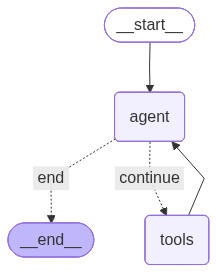

In [17]:
display(Image(app.get_graph().draw_mermaid_png()))

In [18]:
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage

In [19]:
# Main chat loop
def main():
    print('ReAct Agent Chat (type "quit" or "exit" to end)')
    print('-' * 50)

    # Initialize conversation state with system prompt
    messages = [SystemMessage(content=SYSTEM_PROMPT)]

    while True:
        # Get user input
        user_input = input('\nYou: ').strip()

        # Check for exit commands
        if user_input.lower() in ['quit', 'exit', 'q']:
            print('Goodbye!')
            break

        if not user_input:
            continue

        # Add user message to state
        messages.append(HumanMessage(content=user_input))

        # Run the agent
        try:
            result = app.invoke({'messages': messages}, stream_mode='messages')

            # Update messages with the full conversation history
            messages = result['messages']

            # Get the final response
            final_message = messages[-1]

            # Print agent response
            if isinstance(final_message, AIMessage):
                print(f'\nAgent: {final_message.content}')

        except Exception as e:
            print(f'\nError: {str(e)}')
            print('Please try again.')

In [20]:
# main()

## Example

ReAct Agent Chat (type "quit" or "exit" to end)
--------------------------------------------------

You: Show me Python ML libraries

Agent: Based on the GitHub search results for Python machine learning libraries, here are the top libraries you should know:

## **Top Python ML Libraries**

### **1. Best-of-ML-Python Collection** ⭐ 23,094
- **lukasmasuch/best-of-ml-python** - A comprehensive, ranked list of awesome ML libraries with weekly updates
- Excellent starting point for discovering and comparing Python ML libraries

### **2. Low-Code ML Libraries**
- **pycaret/pycaret** ⭐ 9,677 - Open-source, low-code ML library ideal for rapid prototyping and automation
- Features automated ML pipelines, model comparison, and deployment tools

### **3. Gradient Boosting Libraries**
- **catboost/catboost** ⭐ 8,768 - High-performance gradient boosting library with support for CPU/GPU
- Specializes in ranking, classification, regression, and handles categorical features natively

### **4. Domain-Specific ML Libraries**
- **timeseriesAI/tsai** ⭐ 5,979 - State-of-the-art deep learning library specifically for time series data
- Built on PyTorch/fastai, this library offers cutting-edge solutions for sequence modeling

### **5. Applied ML Collections**
- **firmai/industry-machine-learning** ⭐ 7,442 - Curated collection of applied ML notebooks and libraries
- Covers different industries with practical examples of ML in production environments

## **Popular Use Cases**
- **General ML**: PyCaret for low-code rapid development
- **Gradient Boosting**: CatBoost for high-performance ranking/classification
- **Time Series Analysis**: tsai for deep learning on sequence data
- **Library Discovery**: Use the best-of-ml-python ranked list to explore weekly updates

These libraries represent a mix of general ML frameworks, specialized algorithms, and practical application examples across different industries.

You: Tell me what's the difference between Machine Learning and Deep Learning

Agent: Based on the educational resources found and my knowledge, here's a comprehensive explanation of the differences between Machine Learning and Deep Learning:

## **Machine Learning vs Deep Learning: Key Differences**

### **1. Relationship: Subset vs Subset**
- **Machine Learning (ML)**: A subset of Artificial Intelligence
- **Deep Learning (DL)**: A subset of Machine Learning
- **Hierarchy**: AI ⊃ ML ⊃ DL

### **2. Core Concept**

**Machine Learning**:
- Algorithms that learn patterns from data without explicit programming
- Requires feature engineering (humans define what features are important)
- Uses statistical techniques to make predictions or decisions

**Deep Learning**:
- Uses artificial neural networks with multiple layers (hence "deep")
- Automatically learns feature representations from raw data
- Inspired by the structure and function of the human brain

### **3. Data Requirements**

**Machine Learning**:
- Works well with smaller datasets
- Can be effective with structured data (tables, spreadsheets)
- Performance plateaus with more data

**Deep Learning**:
- Requires large amounts of data (thousands to millions of examples)
- Excels with unstructured data (images, text, audio)
- Performance continues to improve with more data

### **4. Feature Engineering**

**Machine Learning**:
- **Manual feature engineering required**
- Domain experts must identify and extract relevant features
- Examples: Creating polynomial features, one-hot encoding, scaling

**Deep Learning**:
- **Automatic feature learning**
- Neural networks learn hierarchical features from raw data
- Example: In image recognition, early layers detect edges, later layers detect shapes, then objects

### **5. Hardware Requirements**

**Machine Learning**:
- Can run on standard CPUs
- Lower computational requirements
- Faster training times

**Deep Learning**:
- Requires GPUs or specialized hardware (TPUs)
- High computational requirements
- Longer training times

### **6. Interpretability**

**Machine Learning**:
- Generally more interpretable
- Models like decision trees, linear regression are easy to understand
- Feature importance can be analyzed

**Deep Learning**:
- Often considered "black boxes"
- Hard to interpret why decisions are made
- Emerging field of explainable AI (XAI) trying to address this

### **7. Common Algorithms**

**Machine Learning**:
- Linear/Logistic Regression
- Decision Trees/Random Forests
- Support Vector Machines (SVM)
- K-Nearest Neighbors

You: Do you remember the questions I asked you?

Agent: Yes, I remember both questions you asked me:

## **Question 1: Python ML Libraries**
You asked: "Show me Python ML libraries"
I searched GitHub and found these key libraries:
1. **best-of-ml-python** - A ranked list of awesome ML Python libraries (23k+ stars)
2. **pycaret** - Low-code ML library (9.6k+ stars)
3. **catboost** - Gradient boosting library (8.7k+ stars)
4. **tsai** - Time series deep learning library (5.9k+ stars)
5. **industry-machine-learning** - Applied ML across different industries (7.4k+ stars)

## **Question 2: ML vs Deep Learning Difference**
You asked: "Tell me what's the difference between Machine Learning and Deep Learning"
I explained the key differences including:
- **Hierarchy**: Deep Learning is a subset of Machine Learning, which is a subset of AI
- **Feature Engineering**: ML requires manual feature engineering, DL learns features automatically
- **Data Requirements**: ML works with smaller datasets, DL needs large datasets
- **Hardware**: ML runs on CPUs, DL requires GPUs
- **Interpretability**: ML models are more interpretable, DL models are "black boxes"

Both questions are related to machine learning concepts, with the first focusing on practical tools (Python libraries) and the second on theoretical understanding (differences between ML and DL).

You: q
Goodbye!

In [21]:
# Main chat loop
# Streaming at graph node level
def main_stream():
    print('ReAct Agent Chat (type "quit" or "exit" to end)')
    print('-' * 50)

    # Initialize conversation state with system prompt
    messages = [SystemMessage(content=SYSTEM_PROMPT)]

    while True:
        # Get user input
        user_input = input('\nYou: ').strip()

        # Check for exit commands
        if user_input.lower() in ['quit', 'exit', 'q']:
            print('Goodbye!')
            break

        if not user_input:
            continue

        # Add user message to state
        messages.append(HumanMessage(content=user_input))

        # Run the agent
        try:
            print('\nAgent: ', end='', flush=True)

            for event in app.stream({'messages': messages}):
                # Process each node's output
                for node_name, node_output in event.items():
                    if node_name == 'agent':
                        # Get the last message from the agent
                        last_msg = node_output['messages'][-1]

                        # Stream the content if it's an AI message
                        if isinstance(last_msg, AIMessage) and last_msg.content:
                            print(last_msg.content, end='', flush=True)

                    elif node_name == 'tools':
                        # Showing tool execution
                        print('\n[Using tools...]', end='', flush=True)

            print()

            final_state = app.invoke({'messages': messages})
            messages = final_state['messages']

        except Exception as e:
            print(f'\nError: {str(e)}')
            print('Please try again.')

In [22]:
main_stream()

ReAct Agent Chat (type "quit" or "exit" to end)
--------------------------------------------------

You: Hello

Agent: Hello! How can I help you today? I can search the web for current information or look up GitHub repositories for coding-related topics. What would you like to know?

You: Give me good Python repositories

Agent: I'll search for some good Python repositories on GitHub to give you recommendations.
[Using tools...]Let me search more specifically for popular Python repositories across different categories:
[Using tools...]Let me try a broader search for popular Python projects:
[Using tools...]I'll search for Python repositories using a broader query to get you some recommendations
[Using tools...]Based on the search results, here are some excellent Python repositories:

## High-Star Popular Repositories:

1. **NirDiamant/RAG_Techniques** (⭐24,341)
   - Advanced techniques for Retrieval-Augmented Generation (RAG) systems
   - Combines information retrieval with generative 